In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io,data
import collections
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from data_loader.data_loader import get_patches, dataset, exp_path

Using TensorFlow backend.


In [2]:
# Read result files and organize them
EXP = 'inc_test_250_3_300'
name = exp_path(EXP, inc=True)
[test_y, probs_binary, probs, patch_threshold, roc_auc] = np.load(
    name.patch_target_path, allow_pickle=True)
[train, valid, test] = np.load(name.target_path, allow_pickle=True)

Work on inc_test_250_3_300

threshold  0.15918854
rate  0.32933564778286256
AUC  0.8368676807280578


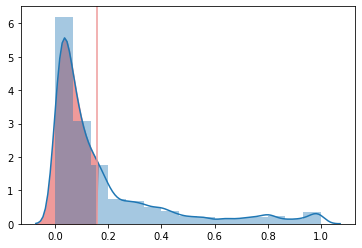

In [3]:
print("Work on " + EXP)
print("\nthreshold ", patch_threshold)
print("rate ", probs_binary.sum()/len(probs_binary))
print("AUC ", roc_auc)
ax = sns.distplot(probs, bins=15, kde=True)

kde_x, kde_y = ax.lines[0].get_data()

#plotting the two lines
p1 = plt.axvline(x=patch_threshold,color='#EF9A9A')

ax.fill_between(kde_x, kde_y, where=(kde_x<patch_threshold) , 
                interpolate=True, color='#EF9A9A')

plt.show()

In [4]:
patient_list = []
type_list = []
for it_type, it_name, it_len in test.idx:
    patient_list.extend([it_name] * it_len)
    type_list.extend([it_type] * it_len)

In [5]:
patient_name = test.idx[15][1]
print("Work on", patient_name)
index_patient = [i for i in range(len(patient_list)) if patient_list[i] == patient_name]
cube_shape = test.coord[index_patient[0]][-3:]

patient_cube = np.zeros(cube_shape)
true_cube = np.zeros(cube_shape)
predict_cube = np.zeros(cube_shape)

identity = np.ones([1, 50, 50])
#test.X = test.X.reshape(np.shape(test.X)[:-1])
for i in index_patient:
    coord = test.coord[i]
    patient_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = test.X[i, :, :].reshape([1, 50, 50])
    true_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * test.y[i]
    predict_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * probs_binary[i]

patient_cube = (patient_cube - patient_cube.min())/(patient_cube.max() - patient_cube.min())

Work on pancreas_083.nii.gz


rate  ['pancreas_167.nii.gz', 'pancreas_086.nii.gz', 'pancreas_081.nii.gz']
false : ['pancreas_167.nii.gz', 'pancreas_086.nii.gz', 'pancreas_081.nii.gz']


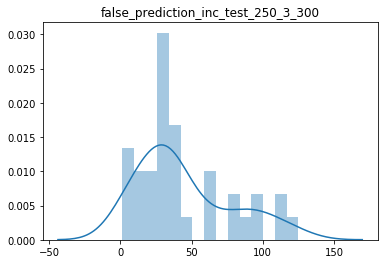

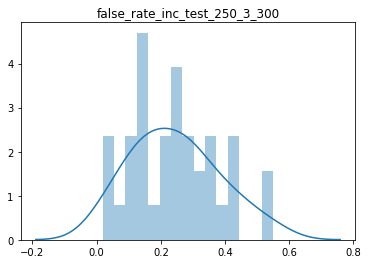

In [6]:
false_list = []
for i in range(len(test.idx)):
    filename = test.idx[i][1]
    index_patient = [i for i in range(len(patient_list)) if patient_list[i] == filename]
    cm = confusion_matrix(test.y[index_patient], probs_binary[index_patient], labels=[1, 0])
    false_list.append((filename, cm[0,1] + cm[1, 0], (cm[0,1] + cm[1, 0])/cm.sum()))
false_list = sorted(false_list, key = lambda s: s[2], reverse = True)
false_list_name = [false_list[j][0] for j in range(len(false_list))]
false_list_false = [false_list[j][1] for j in range(len(false_list))]
false_list_rate = [false_list[j][2] for j in range(len(false_list))]
print("rate ", false_list_name[:3])
false_list = sorted(false_list, key = lambda s: s[1], reverse = True)
print("false :", false_list_name[:3])

sns.distplot(false_list_false, bins=15, kde=True)
plt.title('false_prediction_' + EXP)
plt.show()
sns.distplot(false_list_rate, bins=15, kde=True)

plt.title('false_rate_' + EXP)
plt.show()

In [7]:
patient_name = "pancreas_329.nii.gz"
print("Work on", patient_name)
index_patient = [i for i in range(len(patient_list)) if patient_list[i] == patient_name]
cube_shape = test.coord[index_patient[0]][-3:]

patient_cube = np.zeros(cube_shape)
true_cube = np.zeros(cube_shape)
predict_cube = np.zeros(cube_shape)

identity = np.ones([1, 50, 50])
#test.X = test.X.reshape(np.shape(test.X)[:-1])
for i in index_patient:
    coord = test.coord[i]
    #print(coord)
    patient_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = test.X[i, :, :].reshape([50, 50])
    true_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * test.y[i]
    predict_cube[coord[0]:coord[1], coord[2]:coord[3], coord[4]] = identity * probs_binary[i]

patient_cube = (patient_cube - patient_cube.min())/(patient_cube.max() - patient_cube.min())

Work on pancreas_329.nii.gz


IndexError: list index out of range

In [ ]:
print(confusion_matrix(test.y, probs_binary, labels=[1, 0]))
for index in range(np.shape(patient_cube)[2]):
    print(index)
    cube_shape[2] = 1
    image = patient_cube[:, :, index].reshape(cube_shape)
    image = np.repeat(image, 3, axis=2)
    image[:, :, 1] = image[:, :, 1] * (1 - true_cube[:, :, index]) + true_cube[:, :, index]*120
    image[:, :, 2] = image[:, :, 2] * (1 - predict_cube[:, :, index]) + predict_cube[:, :, index]*120
    plt.imshow(image)
    plt.show()
    